In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import requests
import json
from requests.auth import HTTPBasicAuth
import numpy as np

In [3]:
def feedback_to_tensor(feedback):
    ndarray = np.array(feedback["response"]["response"]["ndarray"])
    feedback["response"]["response"]["tensor"] = {"shape":ndarray.shape,"values":list(ndarray.ravel())}
    del feedback["response"]["response"]["ndarray"]

class ClientException(Exception):
    pass
    
class OAuthClient(object):
    def __init__(self,endpoint,client_key,client_secret):
        self.endpoint = endpoint
        self.token = requests.post(
            "http://{}:{}@{}/oauth/token".format(client_key,client_secret,endpoint),
            headers={"type":"application/json"},
            data={"grant_type": "client_credentials"}).json()['access_token']
    
    def _request(self,method,url,data=None):
        if data is None:
            data = {}
        request = {
            'GET':requests.get,
            'POST':requests.post,
            'DELETE':requests.delete,
            'PUT':requests.put
        }
        response = request[method](
            "http://"+self.endpoint+url, 
            headers={
                "Content-Type":"application/json",
                "Authorization":"Bearer {}".format(self.token)},
            data=json.dumps(data))
        if response.status_code/100!=2:
            raise ClientException(response.text)
        try:
            return response.json()
        except ValueError:
            return response.text
    
    def _get(self,url,data=None):
        return self._request("GET",url,data)
    
    def _post(self,url,data=None):
        return self._request("POST",url,data)
    
    def _delete(self,url,data=None):
        return self._request("DELETE",url,data)
    
    def _put(self,url,data=None):
        return self._request("PUT",url,data)

class ClusterManagerClient(OAuthClient):
    def ping(self):
        return self._get("/ping")
    
    def authping(self):
        return self._get("/api/v1/authping")
    
    def create_deployment(self,deployment):
        response = self._post("/api/v1/deployments",data=deployment)
        return response
    
    def delete_deployment(self,deployment_id):
        response= self._delete("/api/v1/deployments/{}".format(deployment_id))
        return response

class APIFrontEndClient(OAuthClient):
    def ping(self):
        return self._get("/ping")
    
    def predictions(self,request):
        response = self._post("/api/v0.1/predictions",data=request)
        return response
    
    def feedback(self,feedback):
        response = self._post("/api/v0.1/feedback",data=feedback)
        return response

In [4]:
probabilities = {
        0:0.75,
        1:0.89,
        2:0.53
    }
def compute_reward(response,probabilities):
    routing = response['meta']['routing']['0']
    
    return int(np.random.rand()<probabilities[routing])

def test(client,probabilities,n_queries = 1000):
    errors = []
    rewards = []
    routings = []
    for i in range(n_queries):
        if i%100==0:
            print i
        try:
            response = client.predictions(request)
            reward = compute_reward(response,probabilities)
            feedback = {
                "request":request,
                "response":response,
                "reward":reward
            }
            feedback_to_tensor(feedback)
        
            client.feedback(feedback)
            
            rewards.append(reward)
            routings.append(response['meta']['routing']['0'])
            errors.append(False)
        except ClientException:
            rewards.append(np.nan)
            routings.append(np.nan)
            errors.append(True)
    print "There was {} errors".format(np.sum(errors))
    return np.array(rewards),np.array(routings),np.array(errors)

In [5]:
def compute_regret(routings,probabilities):
    max_proba = max(probabilities.values())
    regret_dict = {k:max_proba-proba for k,proba in  probabilities.items()}
    regret = np.apply_along_axis(lambda x:regret_dict[x[0]],1,routings[:,None])
    return regret

In [6]:
def plot_results(routings,rewards,N):
    colors = ['g' if rew else 'r' for rew in rewards]

    plt.figure(figsize=(8,15))
    plt.scatter(routings[:N],N-np.arange(N),linewidth=0,marker='.',c=colors[:N])

In [7]:
with open("./CLUSTER_MANAGER_ENDPOINT",'r') as f:
    cm_endpoint = f.read()[:-1]

with open("../cluster-manager/cluster-manager-client-secret.txt",'r') as f:
    cm_client_secret = f.readline()[:-1]

with open("./API_ENDPOINT",'r') as f:
    api_endpoint  = f.read()[:-1]

with open("./config/deployment_ts.json",'r') as f:
    deployment_ts = json.loads(f.read())
        
with open("./config/deployment_eg.json",'r') as f:
    deployment_eg = json.loads(f.read())

api_ts_client_key = deployment_ts["oauth_key"]
api_ts_client_secret = deployment_ts["oauth_secret"]

api_eg_client_key = deployment_eg["oauth_key"]
api_eg_client_secret = deployment_eg["oauth_secret"]

In [8]:
cmc = ClusterManagerClient(cm_endpoint,"client",cm_client_secret)

In [9]:
cmc.authping()

u'authpong'

In [40]:
created_deployment_ts = cmc.create_deployment(deployment_ts)

In [41]:
created_deployment_eg = cmc.create_deployment(deployment_eg)

In [39]:
cmc.delete_deployment(1)
cmc.delete_deployment(2)

{u'cmstatus': {u'code': 200,
  u'info': u'',
  u'reason': u'',
  u'status': u'SUCCESS'}}

In [136]:
cmc.delete_deployment(2)

{u'cmstatus': {u'code': 200,
  u'info': u'',
  u'reason': u'',
  u'status': u'SUCCESS'}}

In [42]:
client_ts = APIFrontEndClient(api_endpoint,api_ts_client_key,api_ts_client_secret)

In [43]:
client_ts.ping()

u'pong'

In [44]:
client_eg = APIFrontEndClient(api_endpoint,api_eg_client_key,api_eg_client_secret)

In [45]:
client_eg.ping()

u'pong'

In [46]:
print cmc.ping()
print client_ts.ping()
print client_eg.ping()

pong
pong
pong


In [47]:
request = {
    'request':{
        'features':['a','b'],
        'ndarray':[[6,3]]
    },
    'meta':{
        'puid':'0',
        'tags':{}
    }
}

In [48]:
client_ts.predictions(request)

{u'meta': {u'puid': u'0', u'routing': {u'0': 1}},
 u'response': {u'features': [u'proba'], u'ndarray': [[0.8296760813561542]]}}

In [49]:
client_eg.predictions(request)

{u'meta': {u'puid': u'0', u'routing': {u'0': 1}},
 u'response': {u'features': [u'proba'], u'ndarray': [[0.8296760813561542]]}}

In [176]:
rewards_ts, routings_ts, errors_ts = test(client_ts,n_queries=1000)
rewards_eg, routings_eg, errors_eg = test(client_eg,n_queries=1000)

0
100
200
300
400
500
600
700
800
900
There was 0 errors
0
100
200
300
400
500
600
700
800
900
There was 0 errors


In [203]:
regret_ts = compute_regret(routings_ts,probabilities)
regret_eg = compute_regret(routings_eg,probabilities)

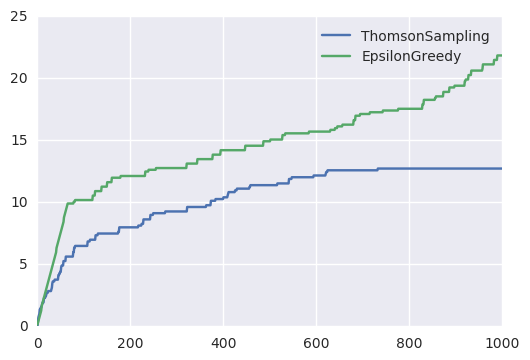

In [222]:
plt.plot(regret_ts.cumsum(),label='ThomsonSampling')
plt.plot(regret_eg.cumsum(),label="EpsilonGreedy")
plt.legend()

In [16]:
import redis
import cPickle as pickle

In [17]:
client = redis.StrictRedis(host="localhost")

In [18]:
client.keys()

['client_id_to_access:key2',
 'client_id_to_access:client',
 'auth:27fa455a-12c8-46b2-8705-61692f70ecc5',
 'client_id_to_access:key1',
 'auth_to_access:fac38d18e76754989f6248004dc851ce',
 'access:f30efa91-1c96-45ba-8f14-d07290b06d67',
 'ts_test2_0',
 'auth:a4118a30-ac43-471f-82a9-d77fd6edda1f',
 'access:a4118a30-ac43-471f-82a9-d77fd6edda1f',
 'auth_to_access:ee16db94e195840785e8cd7b3456eff4',
 'ts_test1_0',
 'access:27fa455a-12c8-46b2-8705-61692f70ecc5',
 'auth:f30efa91-1c96-45ba-8f14-d07290b06d67',
 'auth_to_access:70f17159d1eb538b6a9717a10ded2fcb']

In [57]:
pickle.loads(client.get("ts_test2_0"))

{'best_branch': 1,
 'branches_success': [26, 612, 9],
 'branches_tries': [32, 725, 20],
 'epsilon': 0.05}

In [51]:
pickle.loads(client.get("ts_test1_0"))

{'models_beta_params': [[35, 8], [186, 26], [9, 5]]}

In [21]:
client.delete("ts_test2_0")

1

In [22]:
client.delete("ts_test1_0")

1

In [52]:
import threading

from ipywidgets import widgets

from IPython import display
import time

In [53]:
def get_routing_and_reward(client,probabilities):
    prediction = client.predictions(request)
    routing = prediction['meta']['routing']['0']
    reward = int(np.random.rand()<probabilities[routing])
    return routing,reward,prediction

def send_feedback(client,prediction,reward):
    feedback = {
        "request":request,
        "response":prediction,
        "reward":reward
    }
    feedback_to_tensor(feedback)
    client.feedback(feedback)
    
def plot_all(routings1,routings2,rewards1,rewards2,regrets1,regrets2,N):
    colors1 = ['g' if rew else 'r' for rew in rewards1]
    colors2 = ['g' if rew else 'r' for rew in rewards2]

    fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,8),sharex=True)

    x_range = np.arange(max(len(routings1)-N,0),len(routings1))
    
    ax1.plot(x_range,np.cumsum(regrets1)[-N:],label='Thomson Sampling')
    ax1.plot(x_range,np.cumsum(regrets2)[-N:],label='Epsilon Greedy')
    ax2.scatter(x_range,routings1[-N:],linewidth=0,c=colors1[-N:])
    ax3.scatter(x_range,routings2[-N:],linewidth=0,c=colors2[-N:])
    ax1.legend()
    ax1.set_xlim(x_range[0],x_range[-1])
    ax2.set_ylim(-1,3)
    ax3.set_ylim(-1,3)
    
    yTickMarks = ["A","B","C"]
    ax2.set_yticks(xrange(len(yTickMarks)))
    ax2.set_yticklabels(yTickMarks)
    
    ax3.set_yticks(xrange(len(yTickMarks)))
    ax3.set_yticklabels(yTickMarks)
    
    ax1.set_title("Cumulative Regret")
    ax2.set_title("Thomson Sampling Routing")
    ax3.set_title("Epsilon Greedy Routing")

In [54]:
class PlotThread(threading.Thread):
    def run(self):
        routings_eg = []
        rewards_eg = []
        regrets_eg = []
        predictions_eg = []

        routings_ts = []
        rewards_ts = []
        regrets_ts = []
        predictions_ts = []

        while True:
            if parameters['kill']:
                break
#             print parameters['started']
            probabilities = parameters['probabilities']

            max_proba = max(probabilities.values())
            regret_dict = {k:max_proba-proba for k,proba in  probabilities.items()}

            if parameters['started']:
                routing_eg,reward_eg,prediction_eg = get_routing_and_reward(client_eg,probabilities)
                routing_ts,reward_ts,prediction_ts = get_routing_and_reward(client_ts,probabilities)

                regret_ts = regret_dict[routing_ts]
                regret_eg = regret_dict[routing_eg]

                routings_eg.append(routing_eg)
                rewards_eg.append(reward_eg)
                regrets_eg.append(regret_eg)
                predictions_eg.append(prediction_eg)

                routings_ts.append(routing_ts)
                rewards_ts.append(reward_ts)
                regrets_ts.append(regret_ts)
                predictions_ts.append(prediction_ts)

                if len(routings_eg)>parameters["delay_feedback"]:
                    send_feedback(client_ts,predictions_ts[-parameters["delay_feedback"]],rewards_ts[-parameters["delay_feedback"]])
                    send_feedback(client_eg,predictions_eg[-parameters["delay_feedback"]],rewards_eg[-parameters["delay_feedback"]])

                display.clear_output(wait=True)
                plot_all(routings_ts,routings_eg,rewards_ts,rewards_eg,regrets_ts,regrets_eg,N=100)
                plt.show()
#                 print i
            time.sleep(parameters['time_sleep'])
        print 'Ended'


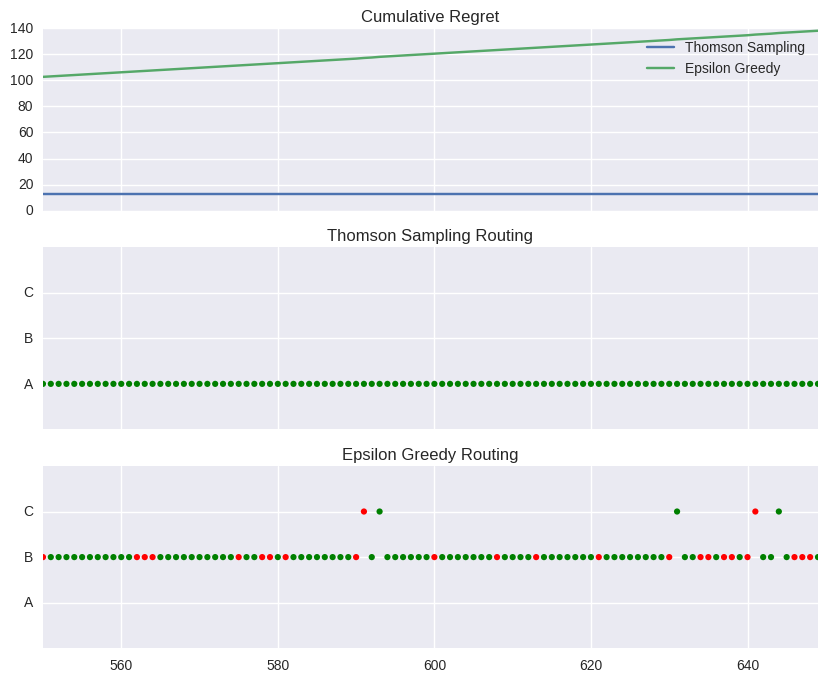

In [55]:
parameters = {
    'probabilities':{
        0:0.75,
        1:0.89,
        2:0.51
    },
    'delay_feedback':5,
    'time_sleep':0.1,
    'started':False,
    'kill':False
}

button_start = widgets.Button(description="STOP" if parameters["started"] else "START")
button_kill = widgets.Button(description="KILL")
slider_A = widgets.FloatSlider(
    value=parameters['probabilities'][0],
    min=0,
    max=1,
    step=0.05,
    description="Model A",
    continuous_update=False)
slider_B = widgets.FloatSlider(
    value=parameters['probabilities'][1],
    min=0,
    max=1,
    step=0.05,
    description="Model B",
    continuous_update=False)
slider_C = widgets.FloatSlider(
    value=parameters['probabilities'][2],
    min=0,
    max=1,
    step=0.05,
    description="Model C",
    continuous_update=False)

def on_click_start(b):
    parameters['started']=parameters['started']==False
    b.description="STOP" if parameters["started"] else "START"
    
def on_click_kill(b):
    parameters['kill']=True
    
def on_update_slider_A(s):
    parameters['probabilities'][0] = slider_A.value

def on_update_slider_B(s):
    parameters['probabilities'][1] = slider_B.value

def on_update_slider_C(s):
    parameters['probabilities'][2] = slider_C.value
    
button_start.on_click(on_click_start)
button_kill.on_click(on_click_kill)

slider_A.observe(on_update_slider_A)
slider_B.observe(on_update_slider_B)
slider_C.observe(on_update_slider_C)

display.display(button_start)
display.display(button_kill)

display.display(slider_A)
display.display(slider_B)
display.display(slider_C)

plot_thread = PlotThread()
_ = plot_thread.start()

In [257]:
parameters

{'delay_feedback': 5,
 'probabilities': {0: 0.75, 1: 0.89, 2: 0.51},
 'started': True,
 'time_sleep': 0.2}

In [240]:
regrets_ts

[[], [], [], [], [], [], [], [], [], []]

In [241]:
routings_ts

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]